# Optimizations

## Loss decrease over epochs


Reference: https://towardsdatascience.com/visualizing-backpropagation-in-neural-network-training-2647f5977fdb

In [ ]:
!pip install hiplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.2/863.2 KB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 KB 38.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from keras import layers,models

In [ ]:
dataset = tf.keras.datasets.boston_housing# Test train split
(x_train, y_train), (x_test, y_test) = dataset.load_data()# Normalize data using training data
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std

In [ ]:
def build_model():    
  model = models.Sequential()    
  model.add(layers.Dense(64, activation='relu',input_shape=(x_train.shape[1],)))    
  model.add(layers.Dense(64, activation='relu'))    
  model.add(layers.Dense(1))    
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [ ]:
num_epochs = 100
model = build_model()
model_history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)
print(test_mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 15.5637 - mae: 2.4638
2.463832378387451


In [ ]:
import hiplot as hip
data = [{'epoch': idx,
         'loss': model_history.history['loss'][idx], 
         'mae': model_history.history['mae'][idx]}
       for idx in range(num_epochs)]
hip.Experiment.from_iterable(data).display()

<IPython.core.display.Javascript object>

## Gradient, Loss and Minima

In [ ]:
import torch

In [ ]:
x = torch.tensor(.0, requires_grad=True)
y = (x-2)**2
optimizer = torch.optim.Adam([x], lr=0.0001)
for i in range(30000):
    optimizer.zero_grad()
    y = (x-2)**2
    y.backward(retain_graph=True)
    optimizer.step()
    # print(x,y)

In [ ]:
print(x,y)

tensor(2.0000, requires_grad=True) tensor(3.6380e-12, grad_fn=<PowBackward0>)


In [ ]:
def inspect_sgd_optimizer():
    x = torch.tensor(1.0, requires_grad=True)
    # Check grad_fn for y. grad_fn is a function "handle", giving access to the applicable gradient function. 
    y = (x-2)**2

    # ToDo: Instantiate different functions of x and check grad_fn. 
    # ToDo: Check optimizer attributes (what are the param_groups, state, state_dict). O
    
    optimizer = torch.optim.SGD([x], lr=0.0001)
    for i in range(30000):
        optimizer.zero_grad()
        y = (x-2)**2
        y.backward(retain_graph=True)
        # Optimizer.step - Performs a single optimization step (parameter update)
        optimizer.step()
        
    print(x, y)

In [ ]:
inspect_sgd_optimizer()

## Gradient and weights visualization
* Vanishing gradients (SIGMOID)


Reference: https://machinelearningmastery.com/visualizing-the-vanishing-gradient-problem/

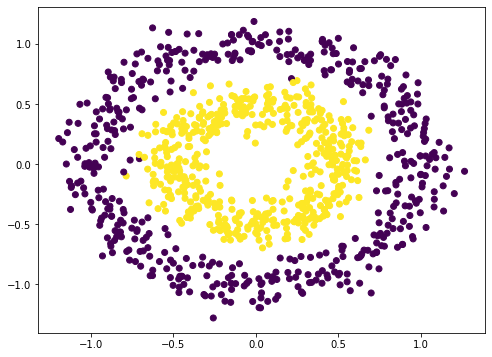

In [ ]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Make data: Two circles on x-y plane as a classification problem
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)

plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [ ]:
def make_mlp(activation, initializer, name):
    "Create a model with specified activation and initalizer"
    model = Sequential([
        Input(shape=(2,), name=name+"0"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"1"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"2"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"3"),
        Dense(5, activation=activation, kernel_initializer=initializer, name=name+"4"),
        Dense(1, activation="sigmoid", kernel_initializer=initializer, name=name+"5")
    ])
    return model
    

In [ ]:
from tensorflow.keras.callbacks import Callback

class WeightCapture(Callback):
    "Capture the weights of each layer of the model"
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) # remember the epoch axis
        weight = {}
        for layer in model.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)

In [ ]:
def plotweight(capture_cb):
    "Plot the weights' mean and s.d. across epochs"
    fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8, 10))
    ax[0].set_title("Mean weight")
    for key in capture_cb.weights[0]:
        ax[0].plot(capture_cb.epochs, [w[key].mean() for w in capture_cb.weights], label=key)
    ax[0].legend()
    ax[1].set_title("S.D.")
    for key in capture_cb.weights[0]:
        ax[1].plot(capture_cb.epochs, [w[key].std() for w in capture_cb.weights], label=key)
    ax[1].legend()
    plt.show()

In [ ]:
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
model = make_mlp("tanh", initializer, "tanh")
print("Before training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
gradhistory, losshistory = train_model(X, y, model)
print("After training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
plot_gradient(gradhistory, losshistory)
initializer = RandomNormal(mean=0.0, stddev=1.0)
batch_size = 32
n_epochs = 100

model = make_mlp("sigmoid", initializer, "sigmoid")
capture_cb = WeightCapture(model)
capture_cb.on_epoch_end(-1)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[capture_cb], verbose=1)
model.evaluate(X,y)

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


32/32 [==============================] - 1s 1ms/step - loss: 0.7995 - acc: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7548 - acc: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7251 - acc: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.7067 - acc: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6965 - acc: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6925 - acc: 0.4930
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6908 - acc: 0.4060
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6902 - acc: 0.4800
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6899 - acc: 0.5140
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 0.6897 - acc: 0.5050
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - los

[0.6165016293525696, 0.6140000224113464]

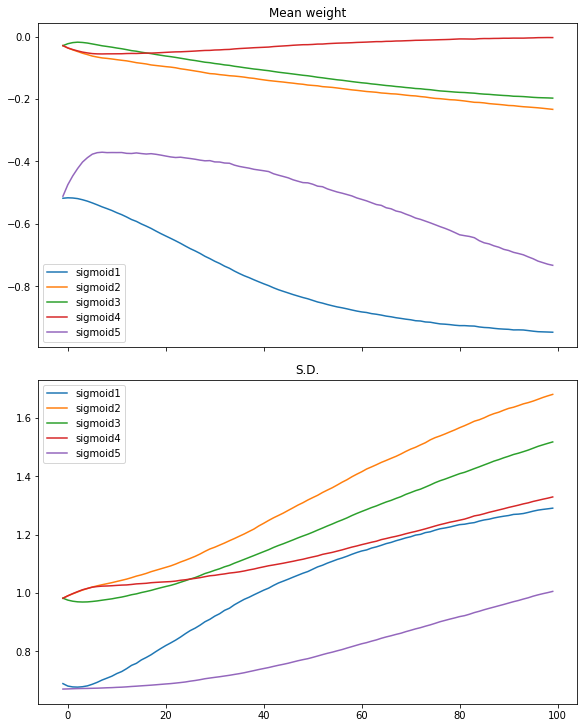

In [ ]:
   
plotweight(capture_cb)

32/32 [==============================] - 0s 1ms/step - loss: 0.0197 - acc: 0.9960
[0.019661886617541313, 0.9959999918937683]


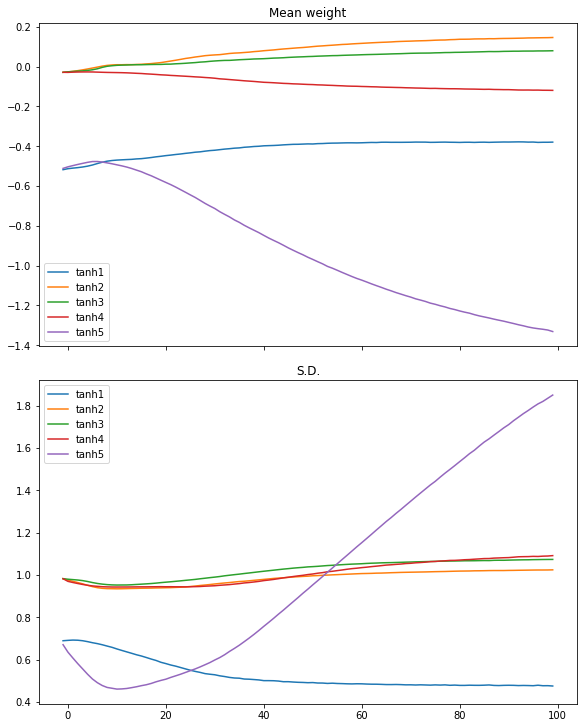

In [ ]:
# tanh activation, large variance gaussian initialization
model = make_mlp("tanh", initializer, "tanh")
capture_cb = WeightCapture(model)
capture_cb.on_epoch_end(-1)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[capture_cb], verbose=0)
print(model.evaluate(X,y))
plotweight(capture_cb)

In [ ]:
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = tf.keras.losses.BinaryCrossentropy()

class weight_capture():
    "Capture the weights of each layer of the model"
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) # remember the epoch axis
        weight = {}
        for layer in model.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)
    

def train_model(X, y, model, n_epochs=n_epochs, batch_size=batch_size):
    "Run training loop manually"
    train_dataset = tf.data.Dataset.from_tensor_slices((X, y))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
    WC = weight_capture(model)

    gradhistory = []
    losshistory = []
    def recordweight():
        data = {}
        for g,w in zip(grads, model.trainable_weights):
            if '/kernel:' not in w.name:
                continue # skip bias
            name = w.name.split("/")[0]
            data[name] = g.numpy()
        gradhistory.append(data)
        losshistory.append(loss_value.numpy())
    for epoch in range(n_epochs):
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                y_pred = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, y_pred)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            if step == 0:
                recordweight()
                WC.on_epoch_end(epoch)
    # After all epochs, record again
    recordweight()
    return gradhistory, losshistory,WC

In [ ]:
def plot_gradient(gradhistory, losshistory):
    "Plot gradient mean and sd across epochs"
    fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(8, 12))
    ax[0].set_title("Mean gradient")
    for key in gradhistory[0]:
        ax[0].plot(range(len(gradhistory)), [w[key].mean() for w in gradhistory], label=key)
    ax[0].legend()
    ax[1].set_title("S.D.")
    for key in gradhistory[0]:
        ax[1].semilogy(range(len(gradhistory)), [w[key].std() for w in gradhistory], label=key)
    ax[1].legend()
    ax[2].set_title("Loss")
    ax[2].plot(range(len(losshistory)), losshistory)
    plt.show()

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Before training: Accuracy 0.5
After training: Accuracy 0.615


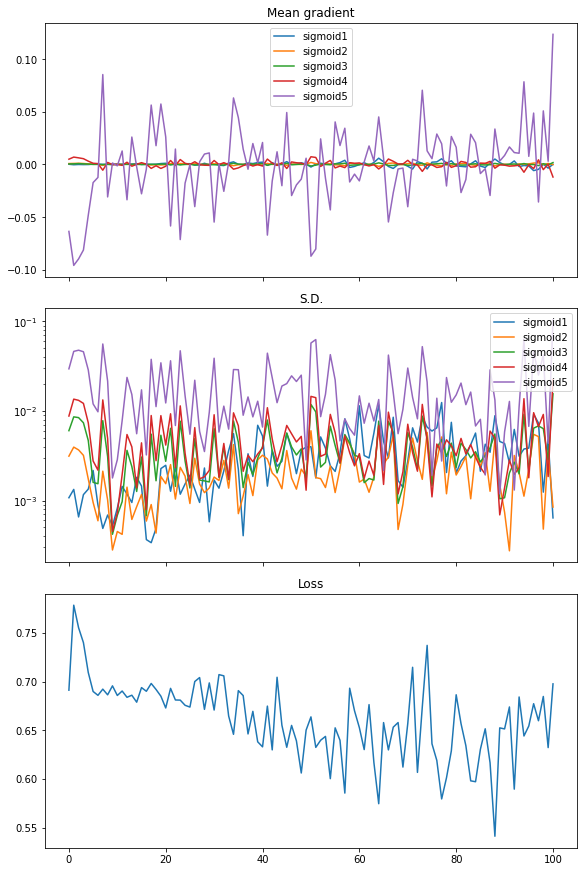

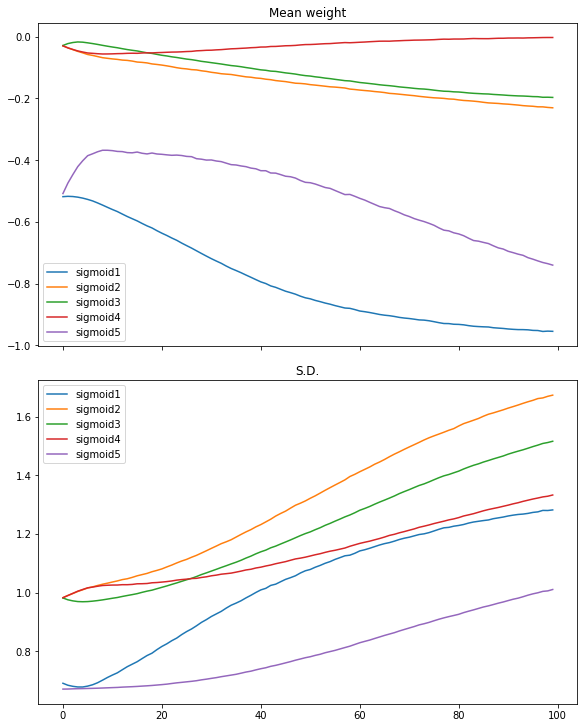

In [ ]:
from sklearn.metrics import accuracy_score
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = tf.keras.losses.BinaryCrossentropy()
model = make_mlp("sigmoid", initializer, "sigmoid")
print("Before training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
gradhistory, losshistory,WeightHist = train_model(X, y, model)
print("After training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
plot_gradient(gradhistory, losshistory)  # Vanishing gradient
plotweight(WeightHist)

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Before training: Accuracy 0.503
After training: Accuracy 0.995


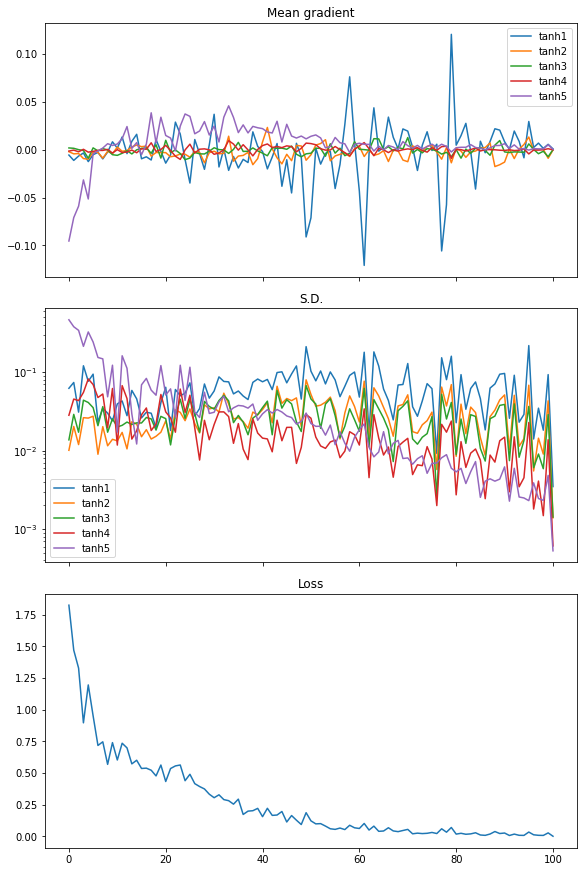

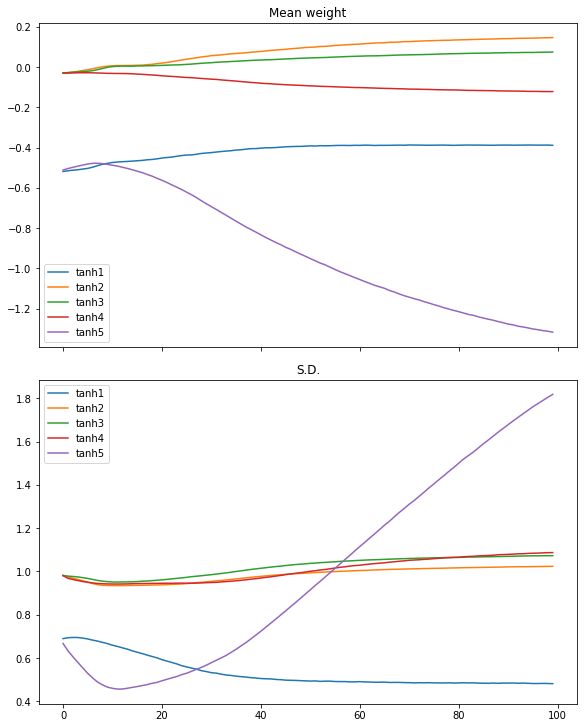

In [ ]:
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = tf.keras.losses.BinaryCrossentropy()
model = make_mlp("tanh", initializer, "tanh")
print("Before training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
gradhistory, losshistory,WeightHist = train_model(X, y, model)
print("After training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
plot_gradient(gradhistory, losshistory)
plotweight(WeightHist)

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Before training: Accuracy 0.502
After training: Accuracy 0.997


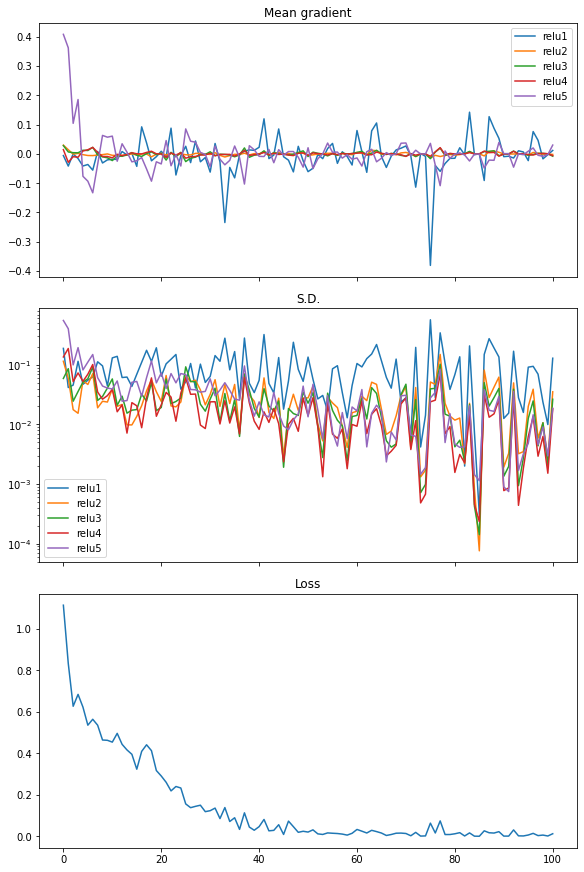

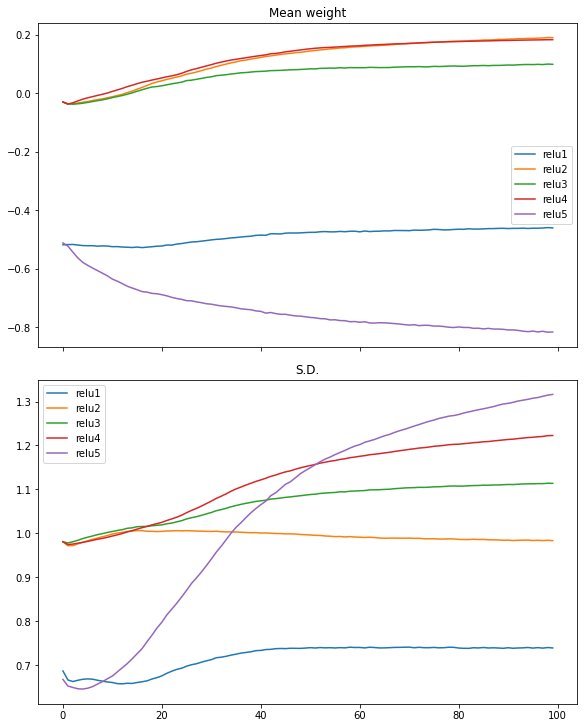

In [ ]:
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = tf.keras.losses.BinaryCrossentropy()
model = make_mlp("relu", initializer, "relu")
print("Before training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
gradhistory, losshistory,WeightHist = train_model(X, y, model)
print("After training: Accuracy", accuracy_score(y, (model(X) > 0.5)))
plot_gradient(gradhistory, losshistory)
plotweight(WeightHist)

## Gradient descent visualization
https://github.com/lilipads/gradient_descent_viz